# Tutorial 03: Comparing a Parametric Disk Model to Observations

In this tutorial we demonstrate how to compare a disk model rendered with `RadJAX` with ALMA interferometric data. 
This is a common workflow when analyzing ALMA CO observations of protoplanetary disks.

⚠️ **Note:** To reproduce this tutorial with real data you will need to supply your own FITS file 
(e.g., ALMA measurement CLEANed (or imaged otherwise) as a data cube). No FITS data are bundled with this repository.

The tutorial illustrates:
- Loading model parameters from YAML (see `tutorial01`)
- Building an azimuthal axsi-symteric disk (see `tutorial01`)
- Interpolating the disk along `rays` (see `tutorial02`)
- Rendering line emission using `line_rte` module
- Comparing model channel maps against a FITS dataset using `visualization` module

In [1]:
import radjax as rj
from radjax import sensor, phys
from radjax import chemistry as chem
from radjax.models import broken_power_law as disk_model
from radjax.core.alma_io import prepare_alma_cube
from radjax.core import visualization

import jax.numpy as jnp

import matplotlib.pyplot as plt

In [2]:
data_path = '../data/HD163296/Flaherty/HD163296_CO_highres_cen.cm.fits'
params_path = '../data/HD163296/Flaherty/HD163296_CO_highres_cen.cm.params.yaml'

## Load model parameters and molecular data

We begin by loading the parametric disk and chemistry configuration from the YAML file.  

- `DiskParams` contains the structural and kinematic setup of the disk.  
- `ChemistryParams` specifies the CO line selection and abundance thresholds.  
- `MolecularData` bundles the energy levels, radiative transitions, and Einstein coefficients 
  for the chosen transition (resolved automatically from the packaged molecular tables).  

Once loaded, we can print each set of parameters for a quick summary.

In [3]:
disk_params = disk_model.disk_from_yaml(params_path)
chem_params = chem.chemistry_from_yaml_path(params_path)
mol = chem.load_molecular_tables(chem_params)

disk_model.print_params(disk_params)
chem.print_params(chem_params)

Disk parameters (parametric broken power law model):
  Midplane T_norm (K):          17.80
  Atmosphere T_norm (K):        87.00
  q (outer exponent):          -0.270
  q_in (inner exponent):       -0.570
  r_break (AU):                 70.00
  log(r_c [AU]):                 2.30
  gamma (Σ slope):              1.000

  Stellar mass (M_sun):         2.300
  Gas mass (M_sun):             0.090

  r_in (AU):                    11.00
  r_scale (AU):                150.00
  z_q0 (AU):                    70.00
  delta (blend exp):            1.000

  Turbulence parameter:         0.060

  Resolution (z/r):               500
  z range (AU):                  0.00 →   200.00
  r range (AU):                 11.00 →   800.00
Chemistry parameters (line selection & thresholds):
  Molecule:                   CO
  Line index (J upper):       2
  Line name:                  CO(2-1)

  CO abundance fraction:      1.000e-04
  Freezeout threshold (K):    19.00
  Dissoc. threshold (cm^-2):  1.256e+21
  D

## Build the CO disk model

Using the parameters above, we now construct the disk fields:

- `temperature(z,r)` in Kelvin  
- `v_phi(z,r)` (azimuthal velocity, including pressure support if enabled)  
- `co_nd(z,r)` the CO number density field  
- `base_disk` container with grids and baseline H₂ fields

In [4]:
temperature, v_phi, co_nd, base_disk = disk_model.co_disk_from_params(
    disk_params, chem_params
)

print("Disk fields summary (azimuthal/mirror symmetric fields):")
print(f"  Temperature:        {temperature.shape}, dtype={temperature.dtype}")
print(f"  CO Number Density:  {co_nd.shape}, dtype={co_nd.dtype}")
print(f"  Azimuthal Velocity: {v_phi.shape}, dtype={v_phi.dtype}")

Disk fields summary (azimuthal/mirror symmetric fields):
  Temperature:        (500, 500), dtype=float64
  CO Number Density:  (500, 500), dtype=float64
  Azimuthal Velocity: (500, 500), dtype=float64


## Visualize the radial–vertical structure
A quick sanity check before comparing to the FITS data.

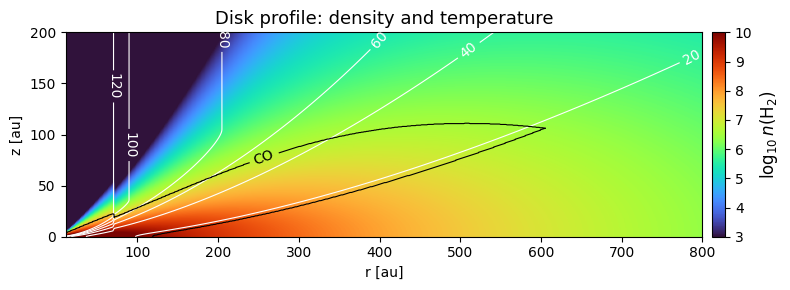

In [5]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(8,3))
visualization.plot_disk_profile_rz(
    ax, base_disk.r, base_disk.z, base_disk.h2_nd, temperature, co_nd
)
plt.tight_layout()

## Load observation parameters

We start by reading the `observation:` section from the YAML file.  
This defines telescope metadata (distance, field of view, velocity frame, geometry, etc.).

In [6]:
obs_params = sensor.params_from_yaml(params_path)
sensor.print_params(obs_params)

 Dataset name:            HD163296 - Flaherty CO(2-1)
 Mode:                    REAL (observed cube)
--------------------------------------------------
 Distance (pc):             122.00
 Field of view (arcsec):    11.000
 Velocity range (m/s):      2000.0 →  10000.0
 VLSR (m/s):               5760.00
--------------------------------------------------
 Number of rays:               100
 Inclination (deg):          47.50
 Phi (deg):                   0.00
 Position angle (deg):      312.00
 Slab thickness z_width (AU):   400.00


## Load the ALMA datacube

Next we load the FITS cube and metadata.  
This provides the observed spectral cube, sky-coordinate grids, and beam kernel.

In [7]:
# Load datacube and associated metadata from FITS
alma_cube = prepare_alma_cube(data_path, obs_params, to_jax=True)

## Build rays through the model disk

We construct a bundle of rays that match the observational geometry  
using the `obs_params` (inclination, position angle, distance, etc.).

In [8]:
rays = sensor.rays_from_params(obs_params, alma_cube.x_sky, alma_cube.y_sky)

## Sample disk fields along rays

The model disk fields (temperature, CO density, velocity) are interpolated onto  
the ray coordinates. This produces 1D profiles along each line of sight.

In [9]:
nd_ray, temperature_ray, velocity_ray = sensor.sample_symmetric_disk__along_rays(
    rays=rays,
    bbox=base_disk.bbox,
    co_nd=co_nd,
    temperature=temperature,
    v_phi=v_phi,
)

## Render synthetic cube

We run the line radiative transfer solver along the sampled rays.  
The output is a synthetic spectral cube with the same frequency grid as the data.

In [10]:
images = sensor.render_cube(
    rays, nd_ray, temperature_ray, velocity_ray,
    nu0=alma_cube.nu0,
    freqs=alma_cube.freqs,
    v_turb=disk_params.v_turb,
    mol=mol,
)

## Convolve with the ALMA beam

To match the observational resolution, the model cube is convolved with  
the synthesized ALMA beam kernel.

In [11]:
model_cube = sensor.fftconvolve_vmap(images, alma_cube.beam_kernel)

## Interactive comparison

Finally, we compare the synthetic model cube to the observed ALMA cube  
using a slider widget that shows channel-by-channel slices.

interactive(children=(IntSlider(value=57, description='frame', max=114), Output()), _dom_classes=('widget-inte…

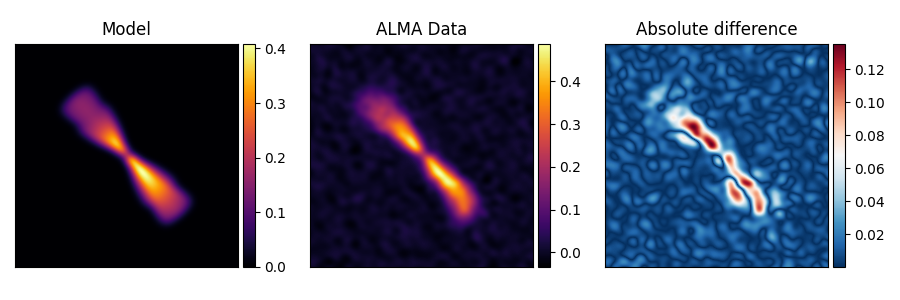

In [13]:
%matplotlib widget
visualization.slider_frame_comparison(
    model_cube, alma_cube.data,
    title1="Model",
    title2="ALMA Data"
)


## Animated channel map comparison

(<matplotlib.animation.FuncAnimation at 0x30f7b9370>,
 './media/tutorial03-channel-map-comparison.gif')

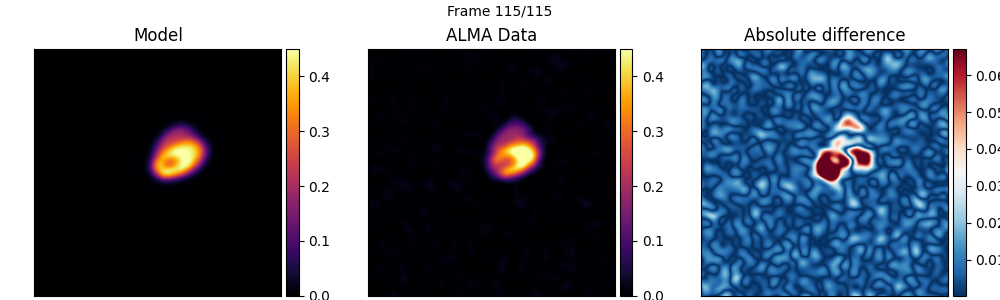

In [16]:
visualization.animate_frame_comparison(
    model_cube, alma_cube.data,
    vmin=0.0, vmax=0.45,
    title1="Model", title2="ALMA Data",
    output='./media/tutorial03-channel-map-comparison.gif'
)

![](./media/tutorial03-channel-map-comparison.gif)